# COVID-19 Cases by States for a Country
[Work in progress]

This notebooks uses data from the  [COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19).

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
from py2neo import Graph
import ipywidgets as widgets

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

#### Setup dropdown menus

In [4]:
query = """
// get list of countries and territories
MATCH (c:Country)
RETURN c.name as country
ORDER BY country
"""
countries = graph.run(query).to_data_frame()['country'].values

In [16]:
style = {'description_width': 'initial'}
state_widget = widgets.Dropdown(options=countries, description='Select country:', value='United States', style=style)
metric_widget = widgets.Dropdown(options=('confirmedRate', 'deathRate'), description='Select metric', style=style)

### Query KG to get Confirmed Cases, Deaths, and Population in a State

NOTE: This notebook currently works only for the United States. Demographics are not available for other countries!

In [17]:
display(state_widget)

Dropdown(description='Select country:', index=239, options=('Afghanistan', 'Aland Islands', 'Albania', 'Algeri…

In [19]:
display(metric_widget)

Dropdown(description='Select metric', index=1, options=('confirmedRate', 'deathRate'), style=DescriptionStyle(…

In [20]:
country = state_widget.value
metric = metric_widget.value
print('Country :', country)
print('Metric:', metric)

Country : United States
Metric: deathRate


In [21]:
# start date for time series
start_date = '2020-04-01'

#### Get confirmed cases and deaths for all counties in a state

In [24]:
query = """
// get all counties (admin2) in a state (admin1)
MATCH (a2:Admin2)-[:IN]->(a1:Admin1)-[:IN]->(:Country{name: $country})

// get COVID-19 cases for counties
MATCH (a2)<-[:REPORTED_IN]-(c:Cases{source: 'JHU'}) 
WHERE c.date >= date($start_date)

// get demographics for counties
MATCH (a2)-[:HAS_DEMOGRAPHICS]->(d:Demographics) 

// aggregate data by state
RETURN a1.name AS name, a1.fips as fips, c.date AS date, 
       sum(c.cases)*100000.0/sum(d.totalPopulation) AS confirmedRate, 
       sum(c.deaths)*100000.0/sum(d.totalPopulation) AS deathRate,
       sum(c.cases) AS cases,
       sum(c.deaths) AS deaths,
       sum(d.totalPopulation) AS population
       
ORDER BY c.date ASC, a1.name
"""
df = graph.run(query, country=country, start_date=start_date).to_data_frame()

In [25]:
df.tail(100)

,name,fips,date,confirmedRate,deathRate,cases,deaths,population
11732,Arizona,04,2020-11-17,4029.202418,90.863484,279896,6312,6946685
11733,Arkansas,05,2020-11-17,4470.368021,75.066766,133694,2245,2990671
11734,California,06,2020-11-17,2687.913998,46.864830,1052285,18347,39148760
11735,Colorado,08,2020-11-17,3110.045468,47.151212,172021,2608,5531141
11736,Connecticut,09,2020-11-17,2639.952378,133.212192,94550,4771,3581504
11737,Delaware,10,2020-11-17,3102.386005,77.830847,29457,739,949495
11738,District of Columbia,11,2020-11-17,2820.899404,96.421027,19309,660,684498
11739,Florida,12,2020-11-17,4345.936300,85.658224,895182,17644,20598139
11740,Georgia,13,2020-11-17,3994.480594,85.185857,411331,8772,10297484
11741,Hawaii,15,2020-11-17,1178.308159,15.541994,16755,221,1421954


Reformat data

In [26]:
# convert neo4j date object to datetime
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=False)  
# pivot table
df_date = df.pivot(index='date', columns='name', values=metric)
df_date.fillna(0, inplace=True)
df_date.head()

name,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,0.570107,0.163331,0.201535,0.227074,0.508731,1.373705,2.317462,1.158511,1.314832,0.416697,1.362145,0.000000,0.578365,1.183141,1.003442,0.303505,0.413200,0.425052,5.895175,0.430507,0.320326,1.661330,3.778070,0.178912,0.752541,0.443087,0.710770,0.264971,1.080099,0.228731,3.996917,0.256824,14.683483,0.143456,0.486517,0.580674,0.800930,0.485356,0.586288,1.041064,0.533903,0.283756,0.199260,0.327867,0.154626,0.817255,0.191082,3.236028,0.072758,1.030175,0.0
2020-04-02,0.565648,0.163331,0.460651,0.223914,0.611505,1.756849,3.099257,1.263830,1.753110,0.702961,1.602008,0.070326,0.571320,1.342185,1.199688,0.369017,0.485311,0.481725,6.672560,0.575675,0.599657,2.131795,4.615796,0.198293,0.883197,0.584533,0.702000,0.257025,1.323992,0.076244,6.001005,0.303809,17.524318,0.213127,0.498318,0.719060,0.923850,0.536446,0.711084,1.041064,0.625514,0.276263,0.537777,0.374973,0.229493,0.817255,0.189295,3.747708,0.072758,1.265125,0.0
2020-04-03,0.789006,0.161517,0.460651,0.219806,0.675263,2.005479,3.629760,1.263830,2.191387,0.795257,1.769944,0.210977,0.566333,1.710778,1.561006,0.364874,0.715732,0.878440,7.886398,0.531945,0.716257,2.690473,5.259069,0.218122,0.985105,0.782245,0.575772,0.319075,1.498201,0.228731,7.228228,0.506349,20.546982,0.271485,0.495833,0.805193,1.016917,0.558802,0.803415,1.041064,0.686048,0.276263,0.613507,0.436040,0.226838,0.817255,0.186369,4.014627,0.141970,1.603695,0.0
2020-04-04,0.909431,0.161517,0.719768,0.215364,0.740814,2.276994,4.579082,1.263830,3.067942,0.945094,1.937105,0.210977,0.629259,1.977165,1.770557,0.391212,0.703921,0.884351,8.812942,0.531945,0.899485,3.043321,5.949693,0.371787,1.188919,0.886573,0.683532,0.316331,1.602727,0.223277,9.367423,0.555988,23.610424,0.339853,0.495833,0.900303,1.125141,0.558802,1.070699,1.987486,0.807115,0.276263,0.750016,0.502077,0.264644,0.817255,0.199075,4.332380,0.141970,1.874303,0.0
2020-04-05,0.930100,0.161517,0.777349,0.212270,0.892918,2.532017,5.249191,1.263830,3.214034,1.076628,2.017250,0.281303,0.626532,2.211084,1.928758,0.627314,0.692604,1.177694,10.191984,0.531945,1.116028,3.263852,6.851724,0.506004,1.451612,1.111439,0.683532,0.434225,1.602727,0.223277,10.178065,0.595150,27.361994,0.379836,0.493102,1.049049,1.225789,0.685523,1.187435,1.987486,0.887826,0.276263,0.792556,0.601205,0.264644,0.817255,0.197895,4.621205,0.212955,1.934269,0.0


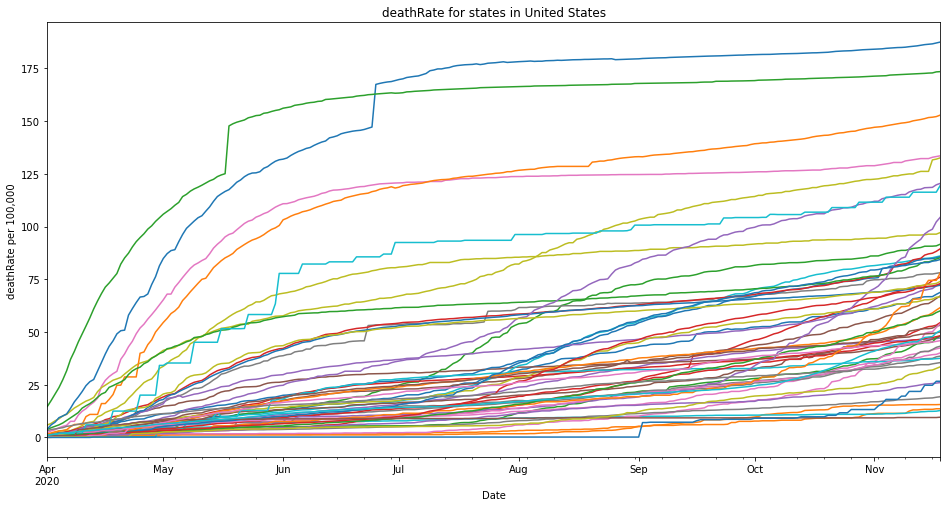

In [27]:
ax = df_date.plot(figsize=(16, 8), legend=False, title=f'{metric} for states in {country}');
ax.set_xlabel('Date');
ax.set_ylabel(f'{metric} per 100,000');

### Case counts by State

In [28]:
# dimensions for subplot layout
cols = 5
rows = math.ceil(df_date.shape[1]/cols)

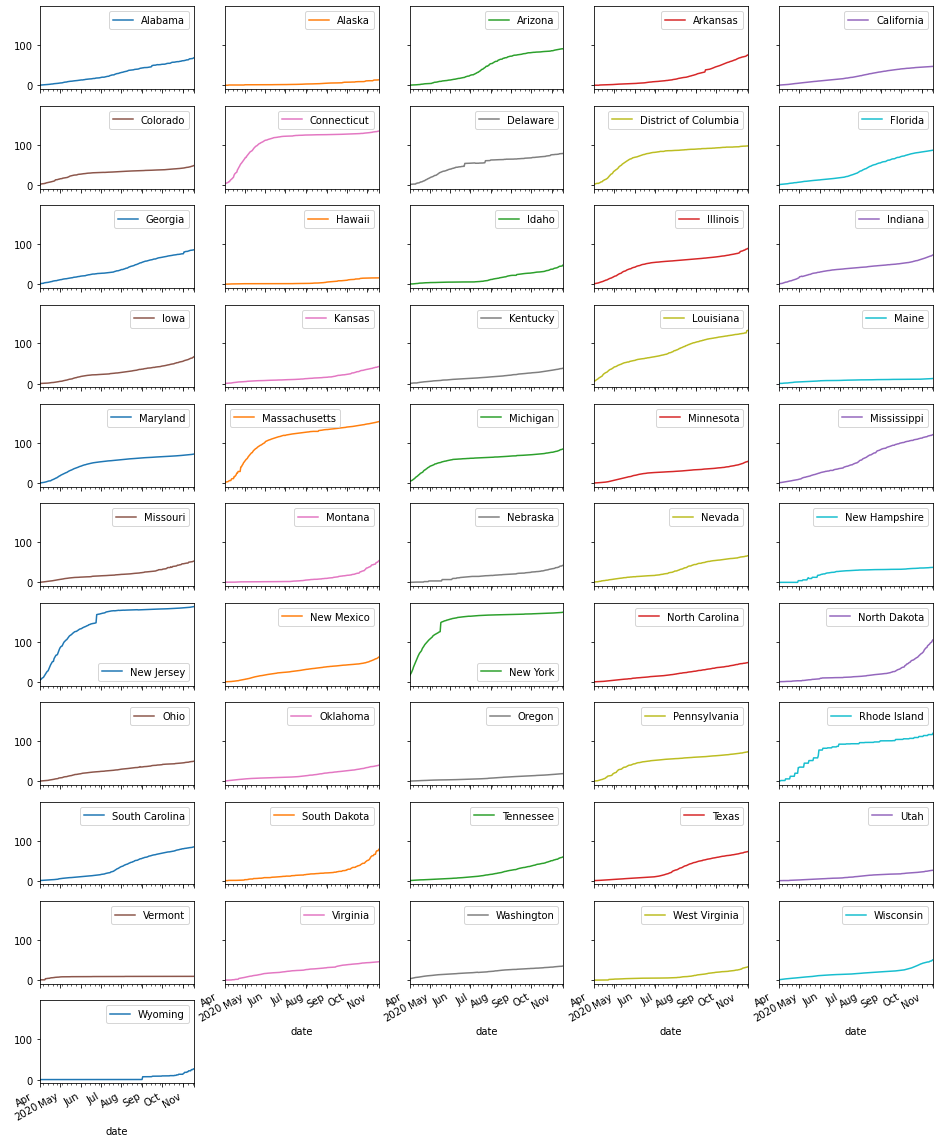

In [29]:
ax = df_date.plot(subplots=True, layout=(rows,cols), sharey=True, figsize=(16, 2*rows));